# An Invitation to the Monte Carlo Method: Simple Integration and Simulation
### Author(s): Joshuah Heath 

In [1]:
addprocs(4)
import PyCall
@everywhere using PyCall
@pyimport IPython.display as IPyD

 ## Contents 
* ** 1.0 - Introduction ** 

 * 1.0.1 - From Solitaire to Neutron Screening: The History of the Monte Carlo Method 
 * 1.0.2 - The Theory behind Monte Carlo Integration


* ** 1.1 - Our First Monte Carlo Simulation: Numerically finding $\pi$ **

 * 1.1.1 - Buffon's Needle and Lazzarini's approximation of $\pi$ 
 * 1.1.2 - $\pi$ from Monte Carlo integration
 * 1.1.3 - Parallelization of Monte Carlo Integration
 * 1.1.4 - Presentation of Monte Carlo Data and Visualization of Error
 * 1.1.5 - Killing Algorithms
 
 
* ** 1.2 - Using Monte Carlo and Importance Sampling to Solve General Integrals **
 *  1.2.1 - Generalizing our $\pi$ Calculation
 *  1.2.2 - Expanding to Multidimensional Integrals
 *  1.2.3 - Importance Sampling and the VEGAS Algorithm
 
 
* ** 1.3 - Monte Carlo for the simulation of random physical systems ** 



## 1.0 - Introduction

In [55]:
IPyD.Image(url="https://upload.wikimedia.org/wikipedia/commons/8/8a/STAN_ULAM_HOLDING_THE_FERMIAC.jpg", width=400)

PyObject <IPython.core.display.Image object>

### 1.0.1 - From Solitaire to Neutron Screening: The History of the Monte Carlo Method

In a nutshell, a Monte Carlo method is some computational algorithm that utilizes repeated random sampling (either via a true random number generator or with respect to some probability distribution). By accepting or rejecting these random points according to some conditions placed on the system, one can estimate some observable or quantity by performing statistical analysis in the large number limit. 

The first true Monte Carlo simulation was done by famed physicist and Nobel laureate Enrico Fermi in the 1930s, with the use of a brass and glass analog computer now known as the Monte Carlo trolley or FERMIAC (pictured above with mathematician Stanislaw Ulam, whom we'll get to in a moment.) Before the birth of the early electronic supercomputer ENIAC (the FERMIAC's namesake), Fermi and his students used the FERMIAC to study the properties of neutrons as they traveled through a material. The placement of the drums was determined by the material in question and the energy of the neutrons ("slow" or "fast"), the latter chosen from a pseudorandom number. The neutron then traveled to a new location (also determined by a set of random numbers), and the trolley rolled along and drew the path of the neutron on top of a scale model of the nuclear device. If the neutron entered a new material, the drums were recalibrated. Below, we see the FERMIAC being used for some calculation:



In [3]:
IPyD.Image(url="https://upload.wikimedia.org/wikipedia/commons/8/8d/FERMIAC.jpg", width=450)

PyObject <IPython.core.display.Image object>

The first full-blown Monte Carlo simulation was born out of the post-war period of nuclear physics research at Los Alamos National Laboratory. Although Enrico Fermi was the first to utilize such statistical sampling for the study of neutron physics, it was Polish-American mathematician Stanislaw Ulam who took the critical step of generalizing the method to large-scale computation. Ulam's insight can be traced back to the mid-1940s, not in an attempt to solve some difficult physical problem or create some new thermonuclear weapon, but instead to his love of solitaire. He wondered if there was any way to calculate the probability of winning a game of Canfield solitaire, a notoriously difficult variant of the traditional card game known for its low probability of winning. Despite the simple nature of the game, the combinatorics behind a winning game is highly non-trivial. Instead of attempting to find an analytical solution to this problem, Ulam imagined playing a hundred games and building an approximate probability distribution by emprically observing how many games were won and how many were lost. Such a simulation could be done on a computer, stochastically sampling the probability density by playing a large number of games via psuedorandom number generation. Subsequently, we build the probability distribution piece by piece. 

The importance of such a method in the physical sciences was noticed by Ulam's colleague at Los Alamos, the polymath and father of game theory John von Neumann. Together with von Neumann, Ulam was able to apply his method of empirically building probability distributions to the problem of radiation shielding. With the average distance a single neutron could travel before striking a nucleus found experimentally, Ulam's empirical construction of some general probability distribution could be used to find the estimated penetration depth of an ensemble of neutrons in a given material. In essence, von Neumann treated the history of a single neutron as a game of solitaire, sampling the probability distribution via pseudorandom number generation to determine if a given neutron will scatter or collide, or if fission will be induced. A "geneology" of each neutron can then be generated. With the creation of the ENIAC (Electronic Numerical Integrator and Computer) at the University of Pennsylvania in early 1946, computer simulations of such a system finally became a reality, and soon Ulam and von Neumann's algorithm was applied to a variety of difficult statistical problems, ranging from the hydrogen bomb to issues in physical chemistry. Ulam and von Neumann chose the moniker "Monte Carlo" upon suggestion by fellow Los Alamos physicist Nicholas Metropolis, in reference to Ulam's uncle who was known to frequent the popular Monacan casino. We'll learn more about Metropolis and his contributions to the now-famous Monte Carlo method later in these notes.


The implementation of the method differs greatly depending on what system (physical, mathematical, economic, etc.) we are talking about. Our goal is to dive into quantum Monte Carlo for many-body systems, but to do that we have to build up a dictionary of basic functions and algorithms to efficiently and simply stochastically sample the given probability distribution, as well as to visualize the results. For that, we begin with a simple Monte Carlo integration example, and then procede to importance sampling and from there dip our toes into some simple physical systems of historical interest before we tackle the big guns. 

### 1.0.2 - The Theory behind Monte Carlo Integration


The reason for taking Monte Carlo integration as our first example is three-fold. First of all, it's a nice, simple introduction that people can understand without any knowledge of physics. Second, we can generalize the functions used in this code for future, more complex Monte Carlo programs. Third, Monte Carlo integration is, in fact, a general extension of regular discrete integration. To see this in it's entirety, we start with the definition of some probability distribution function $\bar{P}(x)$. The probability $P_a^b(x)$ of finding a random variable in this distribution between points $x=a$ and $x=b$ is then given by

\begin{align}
P_a^b(x)=\int_a^b \overline{P}(x)dx\notag
\end{align}

In the case of a uniformly random distribution in the interval $[a,b)$, it is important to note that

\begin{align}
\overline{P}(x)\bigg|_a^b
=\frac{1}{b-a}\notag
\end{align}

If we want the expected value $E(f(x))$ of some function $f(x)$ over the probability distribution, we just have to integrate over this probability distribution:

\begin{align}
E(f(x))&=\int f(x)\overline{P}(x)dx\notag
\end{align}

Therefore, assuming a uniformly random distribution as above, we can estimate the integral of $f(x)$ from a to b as follows:

\begin{align}
\int_a^b f(x)dx&=\frac{1}{N}\sum_{i=0}^{N-1}\int_a^b f(x) dx\notag\\
&=\frac{1}{N}\frac{1}{\overline{P}(x)}\sum_{i=0}^{N-1}\int_a^b f(x)\overline{P}(x)dx\notag\\
&=\frac{b-a}{N}\sum_{i=0}^{N-1}\int_a^b f(x)\overline{P}(x)dx\notag\\
&=\frac{b-a}{N}\sum_{i=0}^{N-1} E(f(x_i))\notag
\end{align}

Because we are considering a uniformly random distribution, it is very easy to find $E(f(x))$ via stochastically sampling across the given data range, selecting only the data that is "within" the function $f(x)$. This gives us a strategy for Monte Carlo integration for integration: calculate the expected value of some function via stochastic sampling, divide by the total number of points in the interval you're sampling, and then multiply by the total length/area/volume of the interval. Note that this is very similar to Simpson's rule or the trapazoidal rule, except here we sum over random points of the function rather than systematically finding some polynomial to tabulate the integral.  

## 1.1 - Our First Monte Carlo Simulation: Numerically finding $\pi$

### 1.1.1 - Buffon's Needle and Lazzarini's approximation of Pi

In [4]:
IPyD.Image(url="https://upload.wikimedia.org/wikipedia/commons/5/5e/Buffon_1707-1788.jpg",width=350)

PyObject <IPython.core.display.Image object>

The calculation of $\pi$ via stochastic sampling is nothing new to Monte Carlo. One of the first estimations of $\pi$ via random simulation is an application of Buffon's needle problem, a mathematical puzzle first proposed by Georges-Louis Leclerc, Comte de Buffon (shown above) in the 18th century. To understand the problem, imagine that we drop a needle on a wood panel floor, with each panel of the same width. What is the probability that a needle will fall on the border between a two panels? If we take a needle of length of length $\ell$ and a floor with boards of width $w$, we can quantify this probability by defining the angle $\theta$ between the needle and the plane perpendicular to the panel border. If the end of the needle that is farthest away from the border is within a horizontal distance of $\ell \cos\theta$, the needle will cross the border. We can thus integrate from $\theta=0$ to $\theta=\pi/2$ and divide by the total corresponding width in this region to obtain the solution to Buffon's problem:

\begin{align}
P&=\frac{\int_{0}^{\pi/2} \ell \cos \theta d\theta}{\int_0^{\pi/2} w d\theta}\notag\\
&=\frac{2\ell}{w\pi}
\end{align}

The application of Buffon's probability to the experimental determination of $\pi$ was first noticed by Mario Lazzarini at the dawn of the 20th century. By simply rearranging the above formula, we find a relationship for $\pi$ that depends upon a Monte Carlo-style stochastic sampling:

\begin{align}
\pi=\frac{2\ell}{P w}
\end{align}

Due to the simple nature of this system, it would be a reasonable starting point to begin with Buffon's needle problem and see if we can obtain a value for $\pi$. The algorithm is simple:

1) Drop N needles of length $\ell$ onto a "board" with $n+1$ panels and n borders a distance $w$ apart.

2) Count the number of needles $N'$ that land on a border.

3) Calculate the probability $P=\frac{N'}{N}$, and subsequently find the value of $\pi$ via $\frac{2\ell}{Pw}$

The easiest way to do this is by setting the width to $w$ in some arbitrary units. We can then initialize the number of needles on the border to be zero (e.g., on_border=0), and loop through $N$ Monte Carlo steps. During each step, we'll throw a needle of length $\ell$ onto the board, determine if its on the border, and, if it did indeed fall on the border between two panels, add it to on_border. If we take the panels to be arranged in the y-direction, then we can simplify our work by only taking simulating the initial $y$-point of the head and the relative angle $t$ between the needle head and the horizonal axis. The code is given below:

In [5]:
# MC_Buffon
# author(s): Joshuah Heath
#
# function to calculate the value of Pi via a simple Monte Carlo simulation of Buffon's problem 
#
#==============================================================================================#

@everywhere function MC_Buffon(N::Int,l::Any,n::Int) 
    
    # N = number of Monte Carlo steps
    # l = length of needle in some arbitrary units
    # n = number of borders between panels on our board
    
    on_border = 0;   # initalize the number of needles on the border
        
    w=1;   # set the width of the panels to one in some arbitrary units 
    
    for i = 1 : N   # loop over all N Monte Carlo steps                            
        
        y1 = (n+1)*rand()   # choose some random y-coordinate for the needle head between 0 and n+1
        
        t = 2pi*rand()   # choose some random orientation for the needle with respect to the horizontal
        
        y2=l*sin(t)+y1   # find the y-coordinate of the needle tail from the angle t
            
        
        for j in 1 : n   # loop over borders
            
            if y1 < j < y2 || y2 < j < y1   # check if the needle fell on a border
                
                on_border += 1   # if the needle fell on border, add it to on_border
            end
        end
        
    end

    return 2*l/((on_border/N)*w)   # find pi
    
end

Let's try this code out by taking for 3408 Monte Carlo steps--the same amount of steps Lazzarini took with his initial calcualtion. To try and obtain a reasonable value, I will take a board with 101 panels (and hence 100 borders):

In [6]:
MC_Buffon(3408,1,100)

3.2272727272727275

Increasing the number of Monte Carlo points and the number of panels, we get a much better value of $\pi$:

In [7]:
MC_Buffon(1000000,1,1000)

3.144762869155851

______________________________________________________________________________________________________________________
** Coding Challenge **: _ Generalize Buffon's needle equation for a square grid and appropriately modify the Monte Carlo code. Can you get a reasonable value of $\pi$ with fewer Monte Carlo steps? _
______________________________________________________________________________________________________________________


### 1.1.2 - $\pi$ from Monte Carlo integration

Of course, we can do better than this. The above code is slow and inaccurate. What we want to do now is to perform a full-scale Monte Carlo integration to calculate $\pi$. The algorithm, of course, is quite a bit different. Recall the integral defined above:

\begin{align}
\int_a^b f(x) dx=\frac{b-a}{N}\sum_{i=0}^{N-1} E(f(x))
\end{align}

Let us sample the range $x,y\in [-1,1]$. Hence, the value of $\pi$ can be found by multiplying the total area $((1+1)^2=4)$ by the expected value, which is just the number of points in the unit circle divided by the total number of points $N$. The algorithm for the Monte Carlo estimation of $\pi$ is thus quite simpler than the Buffon's needle code above:

1) Drop N points in the space $x,\,y\in [-1,1]$

2) Count the number of points $N'$ that land in the unit circle

3) Calculate the value $N'/N$, and subsequently find the value of $\pi$ by multiplying $N'/N$ by $4$

The code is shown below:

In [8]:
# MC_Pi
# author(s): Joshuah Heath
#
# function to calculate the value of Pi via simple Monte Carlo integration
#
#==============================================================================================#

@everywhere function MC_Pi(N::Int)
    
    # N=number of Monte Carlo points
    
    in_circle = 0;   # initialize the number of points inside the circle
        
    for i = 1 : N   # loop over all N Monte Carlo steps 
        
        x = 2 * rand() - 1   # find x and y in the interval [-1,1]
        y = 2 * rand() - 1
            
        if x^2 + y^2 < 1.0   # test if the point (x,y) is within the unit circle
            in_circle += 1   # if the point is in the unit circle, add it to in_circle
        end
        
    end

    return 4.0*in_circle/ N   # calculate pi
    
end

This code is much simpler than the Buffon needle code, and can easily be modified for later use. A million Monte Carlo steps yields a reasonable value for $\pi$:

In [9]:
MC_Pi(1000000)

3.139412

A billion Monte Carlo steps yields an even better estimate:

In [10]:
MC_Pi(1000000000)

3.14158254

We can see what is happening visually by modifying the above code to create lists of accepted and rejected points, and plotting the results with PyPlot:

In [11]:
using PyPlot

In [12]:
# MC_visual
# author(s): Joshuah Heath
#
# function to visualize the estimation of Pi via simple Monte Carlo integration
#
#==============================================================================================#

function MC_visual(N::Int)

    # N = number of MC steps
    
    x_list_in=[]   # define empty lists of coordintes both inside and outide the unit circle
    x_list_out=[]
    y_list_in=[]
    y_list_out=[]
    
    sizehint!(x_list_in,N)   # we don't know the size of our lists, so we use sizehint to speed things up
    sizehint!(x_list_out,N)
    sizehint!(y_list_in,N)
    sizehint!(y_list_out,N)
    
    
    for i = 1 : N   # loop over all MC steps
        
        x = 2 * rand() - 1   # find x and y in the interval [-1,1]
        y = 2 * rand() - 1
        
        if x^2 + y^2 < 1.0   # test if the point (x,y) is within the unit circle
            push!(x_list_in,x)   # if the point is in the unit circle, add coordinates to appropriate lists
            push!(y_list_in,y)
        else
            push!(x_list_out,x)   # if the point is outside the unit circle, add coordinates to appropriate lists
            push!(y_list_out,y)
            
        end
        
    end
    
    plot(x_list_in,y_list_in,linestyle="",marker=".",color="blue")   # plot the points in the circle in blue 
    plot(x_list_out,y_list_out,linestyle="",marker=".",color="red")  # plot the points out of the circle in red
        
end

MC_visual (generic function with 1 method)

A good visualization of the data is found with ten thousand MC steps:

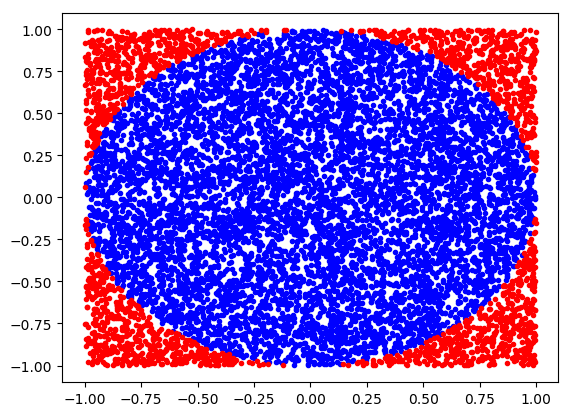

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x323e28b50>

In [13]:
MC_visual(10000)

The MC_visual function, though simple, gives us a sanity check as well as a visualization of the algorithm beyond a numerical result.

______________________________________________________________________________________________________________________
** Coding Challenge **: _ Make a Buffon$\_$visual function that gives us a visualization of N needles falling n+1 boards. Analogous to the code above, color the needles that fall on the panel border blue and those that fall elsewhere red. Color the border of the panels in green.  _
______________________________________________________________________________________________________________________


### 1.1.3 - Parallelization of Monte Carlo Integration

What it comes to Monte Carlo simulation, our goal is to get good data as fast as possible. Good data is characterized by small variance--we'll be dealing with that in the next section. For now, let's look at how to speed up our code. First of all, notice the speed of the Monte Carlo integration compared to the Monte Carlo integration of Buffon's problem. In fact, we can easily see that the integration for 1,000,000 Monte Carlo steps is over 500 times faster than the Buffon simulation!

In [14]:
(@elapsed MC_Buffon(1000000,1,1000))/(@elapsed MC_Pi(1000000))

704.5693887774443

Of course, we can do better than this. This is a relatively simple Monte Carlo algorithm, but in the future we will the algorithms will become more complex and computationally intense. In preparation for these calculations, let us introduce the concept of ** parallel computation ** for Monte Carlo simulation. To do this, we build a function that takes MC_Pi and evenly splits the jobs to our processors:

In [15]:
# parallel_calc
# author(s): Joshuah Heath
#
# function that takes some general function and splits it between your computer's processors
#
#==============================================================================================#

function parallel_calc(f::Function,N::Int,proc::Int=4)
    
    #f = some predefined function
    #N = number of Monte Carlo steps
    #proc = number of additional processors, preset to four
    
    n=round(Int,N/proc);   # split the number of Monte Carlo steps equally between processors 
    
    proc_sum = @parallel (+) for i=1:proc   # loop through the processors and distribute jobs
        f(n)
    end
    
    return proc_sum / proc   # return the average of the parallel jobs
    
end 

Now, we can quickly and efficiently calculate a billion MC steps:

In [16]:
parallel_calc(MC_Pi,1000000000)

3.141602532

Interestingly, the time of completion is highly dependent on the number of MC steps we take. For example, at 1000 MC steps, the parallel function is around 1000 times * slower * than the regular MC_Pi:

In [17]:
(@elapsed MC_Pi(1000))/(@elapsed parallel_calc(MC_Pi,1000))

0.0020029652883763907

Going to a million MC steps, we see somewhat better performance, with the parallel function a around twice as fast as the original MC_Pi: 

In [18]:
(@elapsed MC_Pi(1000000))/(@elapsed parallel_calc(MC_Pi,1000000))

2.1678996016930996

The perfomance of parallel appears to plateau around 2.5 times MC_Pi, as can be seen by simulating a ten million and a billion MC steps:

In [19]:
(@elapsed MC_Pi(10000000))/(@elapsed parallel_calc(MC_Pi,10000000))

2.3779929165393003

In [20]:
(@elapsed MC_Pi(1000000000))/(@elapsed parallel_calc(MC_Pi,1000000000))

2.730736061290356

The reason for this slow down is because there is some overhead--it takes some time for the program to send the jobs to the parallel processors. Only when we increase the number of Monte Carlo steps to above a million do we get a reasonable payoff. Although the speed of parallel compared to MC_Pi is not as extreme as the speed up of MC_Pi compared to MC_Buffon, parallel's $\sim 3\times$ increase in the speed of computation will be valuable for future Monte Carlo simulations, where simulation might take a few hours and the difference between using MC_Pi and parallel will be more prounounced.

There is also an easier way to see the speed up of parallel processing by plotting the elapsed time. Below, we define a simple code to plot the elapsed times of MC_Pi (in blue) and parallel (in red) vs. the number of MC steps:

In [23]:
# pi_time_plotter
# author(s): Joshuah Heath
#
# function that visually compares parallel vs. single processor efficiency in the MC calculation of pi
#
#==============================================================================================#

function pi_time_plotter(N::Int)
    
    #N = number of Monte Carlo points
    
    n=Int64(N/10) # this ensures that you only plot 10 points 

    plot(collect(1:n:N),[@elapsed MC_Pi(i) for i in 10:n:N],linestyle="--",marker=".",color="blue",
        label="Single Processor")
    
    # the above plots MC_Pi for 10 values of MC steps from 10 to N vs. the number of MC steps
    
    plot(collect(1:n:N),[@elapsed parallel_calc(MC_Pi,i) for i in 10:n:N],linestyle="--",marker=".",color="red",
        label="Parallel Processor")

    # the above plots parallel for 10 values of MC steps from 10 to N vs. the number of MC steps
    
    title("Comparison of Parallel vs. Single Processor MC Efficiency")   # make title and labels
    ylabel("Elapsed Time (sec)")
    xlabel("# of random points")

    
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   # anchor the legend
    
    
end

pi_time_plotter (generic function with 1 method)

First, we compare single to parallel processing efficiency for a thousand Monte Carlo steps:

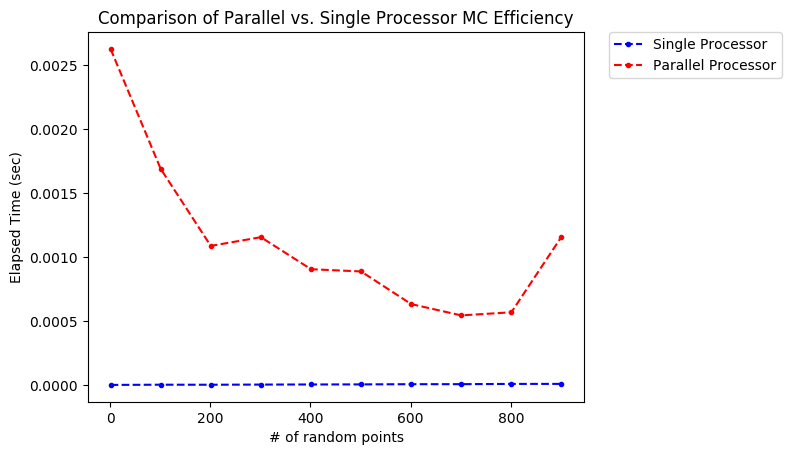

PyObject <matplotlib.legend.Legend object at 0x319542890>

In [24]:
pi_time_plotter(1000)

As expected, the single processor simulation clearly beats the parallel processor calculation. However, as we increase to a million MC steps, the parallel processor beats out the single processors:

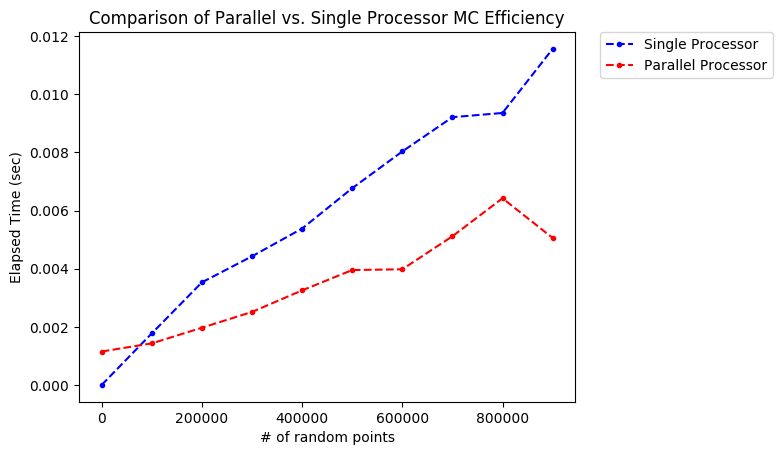

PyObject <matplotlib.legend.Legend object at 0x328e82e90>

In [27]:
pi_time_plotter(1000000)

We can see that the elapsed time of simulation is approximately equal around a hundred thousand MC steps, after which parallel processing begins to win in favor of the single processor. This trend is continued when we look at a billion MC steps:

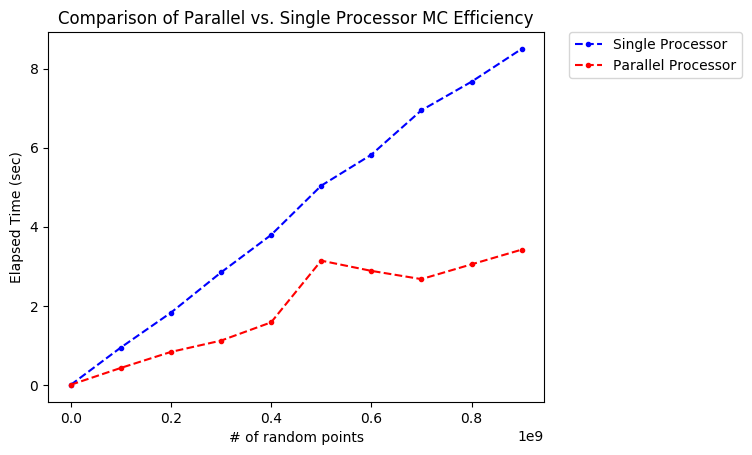

PyObject <matplotlib.legend.Legend object at 0x328e8f490>

In [28]:
pi_time_plotter(1000000000)

Due to its inherent generalization, we will continue to use the parallel function (or some mild modification of it) in future Monte Carlo code. 

### 1.1.4 - Presentation of Monte Carlo Data and Visualization of Error

Now that we have an efficient Monte Carlo algorithm, we want to present this data as we did with the single vs. parallel processor efficiency. If we want to do research-quality work, we won't be able to get anywhere without developing a reasonable means to present our data. To do this, let's write a simple program to plot the output of parallel vs. the number of Monte Carlo steps. Because we know what the value of $\pi$ is, let's also plot the accepted value as a straight line in red. Finally, let's also calculate the percent error and display it in the title. The format used here will be useful in later code where we have to compare with some exact analytical value. For the value of $\pi$, let's import the python package Numpy and use it np.pi as the accepted value.

In [29]:
@everywhere @pyimport numpy as np

In [30]:
# MC_plotter
# author(s): Joshuah Heath
#
# function that plots Monte Carlo data
#
#==============================================================================================#

function MC_plotter(f::Function,N::Int,m::Int)
    
    # N = maximum number of Monte Carlo steps
    # m = number of points to plot
    
    n=Int64(N/m)   # defines the step size between points to plot
    
    pi_list=[parallel_calc(f,i) for i in n:n:N]   # generate list of pi values from parallel for i MC steps 
    
    
    plot(collect(n:n:N),pi_list,linestyle="--",marker=".",
        color="blue",label=string("MC Estimate:  ",round(pi_list[end],6)))
    # in the above, we plot the MC estimate of pi vs. the number of MC steps
    
    axhline(y=np.pi,linestyle="-",color="red",label=string("Numpy Value: ",round(np.pi,6)))    
    # in the above, we plot a horizontal line at the pi value given by numpy
    
    
    per_error=100*abs((pi_list[end]-np.pi)/(pi_list[end]))   # calculate percent error from pi_list
    
    title(string(L"Monte Carlo Estimation of $\pi$--within ",round(per_error,5),"%"))   # make titles and labels
    ylabel("Estimate of π")
    xlabel("# of random points")

    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   # make legend
    
end
        

MC_plotter (generic function with 1 method)

Note that the above can be easily modified for any function--just change the title and comment out the horizontal line at np.pi and percent error calculation.

To get a nice plot, we take a maximum of a million Monte Carlo steps and plot a total of a hundred points:

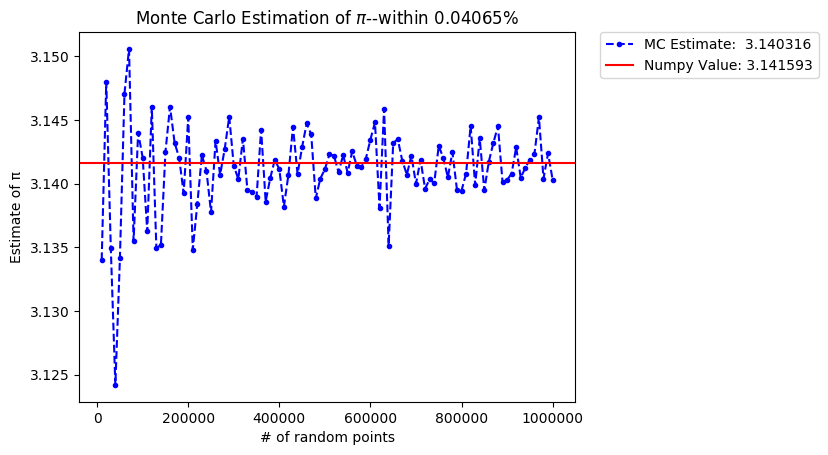

PyObject <matplotlib.legend.Legend object at 0x329312b10>

In [31]:
MC_plotter(MC_Pi,1000000,100)

Although we appear to obtain a reasonable value for $\pi$ (below 0.1%!), it is difficult to see how well the data is converging, or if the error on the MC value of $\pi$ itself is large enough to render the data meaningless. Therefore, to appropriately analyze the data, let us build a new function that calculates a list of M Monte Carlo estimates of $\pi$ at a given value of N. From this list, it can then return the average and standard deviation: 

In [32]:
# stat_calc
# author(s): Joshuah Heath
#
# function that performs statistical analysis of Monte Carlo data at a given value of MC step size
#
#==============================================================================================#

function stat_calc(f::Function,N::Int,M::Int)
    
    # f = some general function
    # N = number of Monte Carlo steps
    # M = number of times to repeat a single MC step to for statistical analysis
    
    avg_list=[parallel_calc(f,N) for j in 1:M]   # create list of MC data of length M 

    avg=sum(avg_list)/M   # calculate average of MC data
    
    stdev=std(avg_list)   # calculate standard deviation of MC data
    
    return avg, stdev
    
end

stat_calc (generic function with 1 method)

Now, we can modify MC_plotter to include error bars to better visualize the convergence of our data:

In [33]:
# MC_errorbar
# author(s): Joshuah Heath
#
# function that plots Monte Carlo data with error bars 
#
#==============================================================================================#

function MC_errorbar(f::Function, N::Int,m::Int,M::Int)

    # f = general function
    # N = maximum number of Monte Carlo steps
    # m = number of points to plot
    # M = number of times to repeat a single MC step to for statistical analysis
    
    n=Int64(N/m)   # defines the step size between points to plot
 
    stat_list=[stat_calc(f,i,M) for i in n:n:N]   # make a list of averages and standard deviations from stat_calc 
    avg_list=[stat_list[i][1] for i in 1:m]   # create list of averages
    stdev_list=[stat_list[i][2] for i in 1:m]   # creat list of standard deviations
            
    
    errorbar(collect(n:n:N),avg_list,yerr=stdev_list, linestyle="--",marker=".",
        color="blue",label=string("MC Estimate:  ",round(avg_list[end],6)))
    # in the above, we plot the averages vs. MC step size with error bars of the standard deviation
    
    axhline(y=np.pi,linestyle="-",color="red",label=string("Numpy Value: ",round(np.pi,6)))
    # in the above, we plot a horizontal line at the pi value given by numpy
        
    per_error=100*abs((avg_list[end]-np.pi)/(avg_list[end]))   # calculate percent error
    
    title(string(L"Monte Carlo Estimation of $\pi$--within ",round(per_error,5),"%"))   # make title and labels    
    ylabel("Estimate of π")
    xlabel("# of random points")
    
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   # make legend
    
end
  

MC_errorbar (generic function with 1 method)

As with MC_plotter, we have made the above very general for ease in future modification.

Now, we plot a hundred values of MC steps with a maximum of a million, with each set of steps performed fifteen times for statistical analysis. The resulting data shows a clear convergence of error:

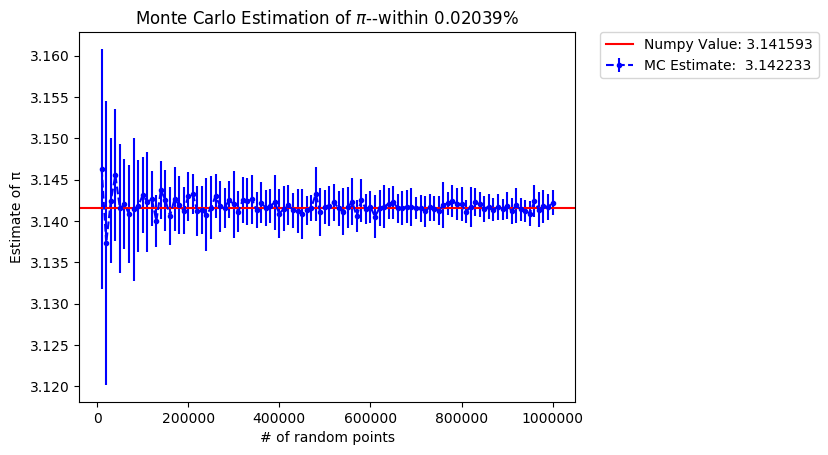

PyObject <matplotlib.legend.Legend object at 0x329312a50>

In [34]:
MC_errorbar(MC_Pi,1000000,100,15)

We can test our result by looking at the convergence of the standard deviation with increasing sample size. Recall, once again, the Monte Carlo estimation of the integral of some general function $f(x)$: 

\begin{align}
\int_a^b f(x) dx=\frac{b-a}{N}\sum_{i=0}^{N-1} E(f(x_i))
\end{align}

The st.dev. square can easily be calculated:

\begin{align}
\sigma_{int}^2 &=\sigma^2\left(
\frac{b-a}{N}\sum_{i=0}^{N-1}E(f(x_i))
\right)\notag\\
&=\frac{b-a}{N^2}\sigma^2\left(\sum_{i=0}^{N-1}E(f(x_i))\right)
\end{align}

If the random variables $x_i$ are uncorrelated, we can easily simplify the above further:

\begin{align}
\sigma_{int}^2&=\frac{b-a}{N^2}\sigma^2\left(\sum_{i=0}^{N-1}E(f(x_i))\right)\notag\\
&=\frac{b-a}{N^2}\sum_{i=0}^{N-1} \sigma^2\left(E(f(x_i))\right)\notag\\
&=\frac{b-a}{N}\sigma^2(E(f(x))
\end{align}

Therefore, we find that the st.dev. goes as the inverse of the square of the sample size:

\begin{align}
\sigma_{int}\propto \frac{1}{\sqrt{N}}
\end{align}

To test this result, we plot the numerically calculated st.dev. alongside $1/\sqrt{N}$:

In [35]:
# MC_errorbar_visual
# author(s): Joshuah Heath
#
# function that plots the error convergence in Monte Carlo data
#
#==============================================================================================#

function MC_errorbar_visual(f::Function, N::Int,m::Int,M::Int)

    # f = general function
    # N = maximum number of Monte Carlo steps
    # m = number of points to plot
    # M = number of times to repeat a single MC step to for statistical analysis
    
    n=Int64(N/m)   # defines the step size between points to plot
 
    stat_list=[stat_calc(f,i,M) for i in n:n:N]   # make a list of averages and standard deviations from stat_calc 
    stdev_list=[stat_list[i][2] for i in 1:m]   # creat list of standard deviations
            
    
    plot(collect(n:n:N),stdev_list,linestyle="--",marker=".", color="blue") # plot the list of st.dev. from MC data
        
    plot(collect(n:n:N),[1/sqrt(i) for i in n:n:N],linestyle="--",color="red") # plot the prediction for the st.dev.

    
    title(string("Convergence of Error bars in MC Data"))   # make title and labels    
    ylabel("Standard Deviation")
    xlabel("# of random points")
    
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   # make legend
    
end
  

MC_errorbar_visual (generic function with 1 method)

Running a maximum of a million samples in steps of a hundred, we find roughly the expected behavior, with each sample repeated fifteen times for statistical analysis: 

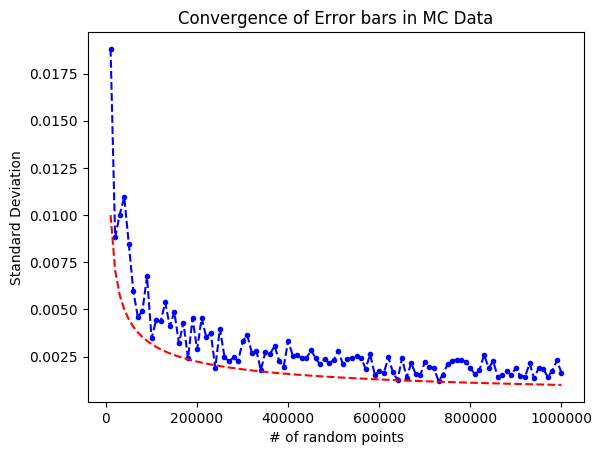

/Users/jtheath/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [36]:
MC_errorbar_visual(MC_Pi,1000000,100,15)

Running ten million samples with each point repeated forty times gives even better agreement, though takes a while longer to run:

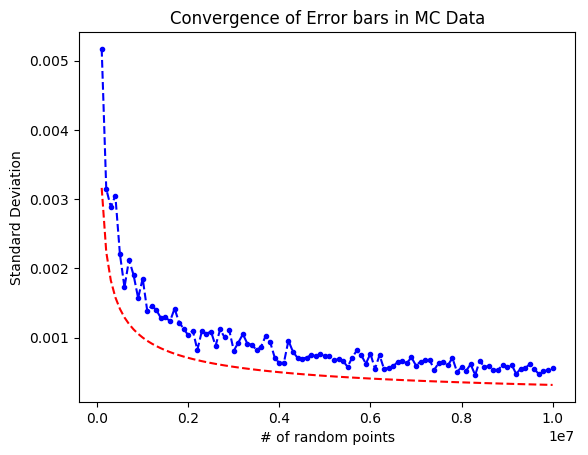

In [37]:
MC_errorbar_visual(MC_Pi,10000000,100,40)

______________________________________________________________________________________________________________________
** Coding Challenge **: _ Perform a similar statistical analysis to the MC$\_$Buffon simulation. Can you get faster convergence by changing the length of the needle or the width of a panel? Does the square grid give a faster convergence? _
______________________________________________________________________________________________________________________


### 1.1.5 - Killing Algorithms

Although we can now present our data on a beautiful plot, we have a remaining issue. When we do real Monte Carlo simulations, we might want to only perform the simulation until we reach a certain error. For example, in the above, we might be satisfied by having an error bars of 0.002, and wish to kill the MC simulation then. This will be useful when we just want to get a rough estimate of what's happening in the simulation. For this purpose, let us define a general function MC_killer which will kill a Monte Carlo program after it reaches a certain number of points with error bars of size C:

In [38]:
# MC_killer
# author(s): Joshuah Heath
#
# function that kills a Monte Carlo program after MAX iterations of points with error bars of size C
#
#==============================================================================================#

function MC_killer(f::Function, N::Int64, n::Int64, M::Int64, C::Float64, MAX::Int64)

    # f = general function
    # N = maximum number of Monte Carlo steps
    # m = number of points to plot
    # M = number of times to repeat a single MC step to for statistical analysis
    # C = cutoff for error bars
    # MAX = max number of points with error bars at C
     
    avg_list=[]   # define empty lists for averages and standard deviations 
    stdev_list=[]
    
    sizehint!(avg_list,N)   # use sizehint incease we are dealing with large lists
    sizehint!(stdev_list,N)
    
    N_end=0;   # this will count the number of times we have error bars smaller than C; used for presentation of data
    
    for i in n:n:N   # loop over all MC steps
        avg,stdev=stat_calc(f, i, M)   # call stat_calc for average and standard deviation
        if length(stdev_list[stdev_list.<C])<MAX   # only add values if we have less than MAX error bars of length C
            push!(avg_list,avg)
            push!(stdev_list,stdev)
            N_end += 1
        elseif length(stdev_list[stdev_list.<C])>=MAX   # if we have MAX error bars of length C, kill the program
            break
        end
    end
    

    return avg_list, stdev_list, N_end
    
end

MC_killer (generic function with 1 method)

Now, we can create a new function that calls MC_killer and plots the data up to a specified accuracy. We generalize the code even further for use in the future:

In [39]:
# MC_smartplot
# author(s): Joshuah Heath
#
# function that plots Monte Carlo data with error bars up to a specified error cutoff
#
#==============================================================================================#

function MC_smartplot(f::Function,target::String,accepted::Any,N::Int64,m::Int64,M::Int64,C::Float64,MAX::Int64)

    # f = general function
    # target = what value you want to show in the title
    # accepted = expected value
    # N = maximum number of Monte Carlo steps
    # m = number of points to plot
    # M = number of times to repeat a single MC step to for statistical analysis
    # C = cutoff for error bars
    # MAX = max number of points with error bars at C

    
    n=Int64(N/m);   # defines the step size between points to plot
    
    avg_list,stdev_list,N_end=MC_killer(f,N,n,M,C,MAX)   # calls MC_killer to get averages and standard deviations

    
    
    errorbar(collect(n:n:(n*N_end)),avg_list,yerr=stdev_list, linestyle="--",marker=".",
        color="blue",label=string("MC Estimate:  ",round(avg_list[end],6)))
    # in the above, we plot the averages vs. MC step size with error bars of the standard deviation
    
    if accepted != "None"   # only if expected doesn't equal "None" do we plot the accepted value
        axhline(y=accepted,linestyle="-",color="red",label=string("Accepted Value: ",round(np.pi,6)))
    end

        
    per_error=100*abs((avg_list[end]-np.pi)/(avg_list[end]))   # calculate the percent error
    
    title(string("Monte Carlo Estimation of ", target,L"; $\sigma_N=$",round(stdev_list[end],5)," at N=",(n*N_end)))    
    ylabel("Monte Carlo Estimate")   # plot title and labels
    xlabel("# of Monte Carlo steps")
    
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   # plot the legend
    
end

MC_smartplot (generic function with 1 method)

Now, in MC_smartplot, we call MC_Pi, tell it we are calculating $\pi$, and use numpy's value of $\pi$ as our accepted value. We ask it to perform a maximum of a million Monte Carlo steps, going in intervals of a hundred, with fifteen runs at each data point. At ten instances of a standard deviation less than $0.002$, we kill the program:

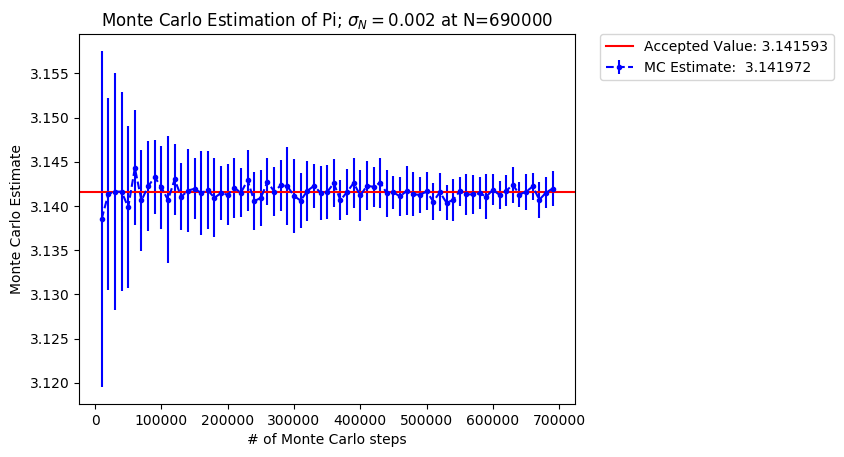

PyObject <matplotlib.legend.Legend object at 0x32adce510>

In [40]:
MC_smartplot(MC_Pi,"Pi",np.pi,1000000,100,15,0.002,10)

The MC_smartplot contains almost everything we've written so far: it calls MC_killer, which calls stat_calc to find the averages and error, which in turn calls parallel with MC_Pi as the input function. 

______________________________________________________________________________________________________________________
** Coding Challenge **:  _ Modify MC$\_$smartplot to show the convergence of MC$\_$Pi alongside MC$\_$Buffon. Which converges faster? Can you find certain parameters in the Buffon system that makes the MC$\_$Buffon perform more efficiently than the Monte Carlo integration? _
______________________________________________________________________________________________________________________


## 1.2 - Using Monte Carlo and Importance Sampling to Solve General Integrals

### 1.2.1 - Generalizing our $\pi$ Calculation

In [41]:
IPyD.Image(url="https://upload.wikimedia.org/wikipedia/commons/4/4e/Eniac.jpg",width=700)

PyObject <IPython.core.display.Image object>

Now that we have mastered the calculation of $\pi$, we can move onto generalizing the above to the determination of * any * integral. Above, we see the afore-mentioned ENIAC, where the first numerical Monte Carlo integration was performed in the mid-20th century. For our purposes, we define a MC_int function modeled on our MC_Pi code, except now it finds the integral of some pre-defined function f(x):

In [42]:
# MC_int
# author(s): Joshuah Heath
#
# function that performs Monte Carlo integration on some general function f(x)
#
#==============================================================================================#

@everywhere function MC_int(f::Function,N::Int64, range::Any)
    
    # f = general function
    # N = maximum number of Monte Carlo steps
    # range = list of min and max values defining the interval
    
    x_min = range[1]   # get min and max values of x from range
    x_max = range[2]
    
    
    in_integral = 0;   # initialize the counter for points under the function
    
    
    y_max=findmax(map(f,collect(x_min:x_max)))[1]   # find the max of the function in the interval

    y_min=findmin(map(f,collect(x_min:x_max)))[1]   # find the min of the function in the interval

    
    for i = 1 : N   # loop over all samples
        
        x=rand()*(x_max-x_min)+x_min   # pick a random point in the range
        y=rand()*(y_max-y_min)+y_min
        
        if 0< y < f(x)   # if the y coordinate is between the x-axis and f(x) with f(x)>0, add it to in_integral
            in_integral += 1
        end
        
        if f(x)<y<0   # if the y coordinate is between the x-axis and f(x) with f(x)<0, subtract it from in_integral
            in_integral -=1
        end
        
    end

    return (in_integral/N)*((x_max-x_min)*(y_max-y_min))   # calculate the integral
    
    
end

We define a simple function f_1(x) that returns x:

In [43]:
@everywhere function f_1(x)
    
    return x
    
end

Performing a million samples in the interval $[0,10]$, we find the expected result:

In [45]:
MC_int(f_1,1000000,[0,10])

49.9641

Defining a much more difficult function, we see that the result still agrees with the exact value (in this case, $0.524188$):

In [46]:
@everywhere function f_2(x)
    
    return sin(x+x^2-x^3)
    
end

In [48]:
MC_int(f_2,1000000,[0,1])

0.5238897374895787

We can easily visualize the data as we did before with our $\pi$ calculation:

In [49]:
function MC_visual_int(f::Function,N::Int,MIN::Int64, MAX::Int64)

    
    x_list_in=[]
    x_list_out=[]
    y_list_in=[]
    y_list_out=[]
    
    sizehint!(x_list_in,N)
    sizehint!(x_list_out,N)
    sizehint!(y_list_in,N)
    sizehint!(y_list_out,N)
    
    y_max=findmax(map(f,collect(MIN:MAX)))[1]

    y_min=findmin(map(f,collect(MIN:MAX)))[1]

    
    for i = 1 : N
        
        x=rand()*(MAX-MIN)+MIN
        y=rand()*(y_max-y_min)+y_min
 
        if 0<y < f(x) || f(x)<y<0
            push!(x_list_in,x)
            push!(y_list_in,y)
        
        else
            push!(x_list_out,x)
            push!(y_list_out,y)
        
        end
        
    end
    
    plot(x_list_in,y_list_in,linestyle="",marker=".",color="blue")
    plot(x_list_out,y_list_out,linestyle="",marker=".",color="red")
        
end

MC_visual_int (generic function with 1 method)

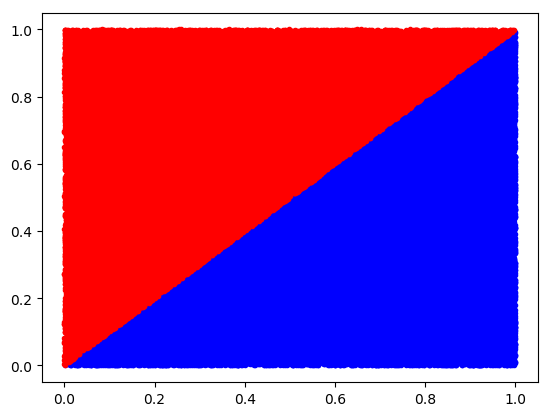

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32b485910>

In [50]:
MC_visual_int(f_1,100000,0,1)

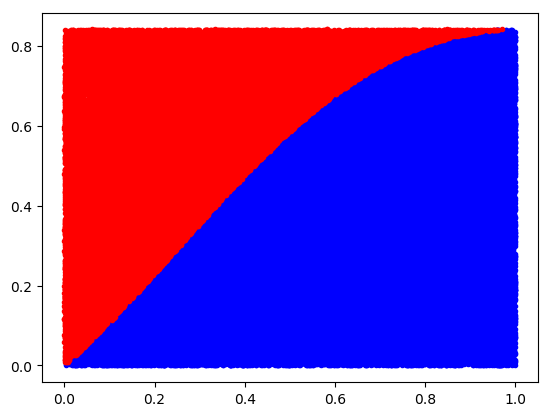

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x329be1a90>

In [51]:
MC_visual_int(f_2,100000,0,1)

______________________________________________________________________________________________________________________
** Coding Challenge **:  _ Generalize MC$\_$smartplot and its sister algorithms to take in some general interval. Perform statistical analysis on the integrals of the two functions given above at the specified range. Does the standard deviation still go as $1/\sqrt{N}$? Though such a generalization of MC$\_$smartplot is trivial and somewhat tedious, it is useful practice in generalizing this important function. In the future, we will have to generalize it further, when factors such as temperature and magnetic fields come into play. _
______________________________________________________________________________________________________________________


______________________________________________________________________________________________________________________
** Coding Challenge **: _ Write a simple code to calculate an integral of your choice with the trapazoidal rule. Compare with the Monte Carlo method--which converges faster? Repeat with Simpson's rule.  _
______________________________________________________________________________________________________________________


### 1.2.2 - Expanding to Multidimensional Integrals

_ ** Coming Soon **_ 

### 1.2.3 - Importance Sampling and the VEGAS Algorithm

_ ** Coming Soon **_ 

## 1.3 - Monte Carlo for the simulation of random physical systems

_ ** Coming Soon **_ 

In [52]:
IPyD.Image(url="https://upload.wikimedia.org/wikipedia/commons/7/78/HD.3F.191_%2811239892036%29.jpg",width=400)

PyObject <IPython.core.display.Image object>

## - Image Credits

* 1.0 - Stan Ulam holding the FERMIAC. Originally uploaded by Deer*lake (Transferred by Deer*lake) (Originally uploaded on en.wikipedia) [Public domain], via Wikimedia Commons


* 1.0.1 - The FERMIAC. By Nicholas Metropolis [Public domain], via Wikimedia Commons. From "The Beginning of the Monte Carlo Method", by N. Metropolis. Los Alamos Science Special Issue (1987): http://library.lanl.gov/cgi-bin/getfile?00326866.pdf


* 1.1.1 - Portrait of Georges-Louis Leclerc, comte de Buffon, by François-Hubert Drouais [Public domain], via Wikimedia Commons


* 1.2.1 - "U.S. Army Photo", from K. Kempf, "Historical Monograph: Electronic Computers Within the Ordnance Corps" The ENIAC, in BRL building 328. Left: Glen Beck Right: Frances Elizabeth Snyder Holberton. Author unknown, [Public domain], via Wikimedia Commons


* 1.3 - John von Neumann. By ENERGY.GOV (HD.3F.191) [Public domain], via Wikimedia Commons

## - References and Further Reading

* Eckhardt, Roger. "Stan Ulam, John von Neumann, and the Monte Carlo Method", Los Alamos Science Special Issue (1987): http://permalink.lanl.gov/object/tr?what=info:lanl-repo/lareport/LA-UR-88-9068


* Gonçalo, Abecasis. "Monte Carlo Integration", Biostatistics 615/815, Lecture 22: http://csg.sph.umich.edu/abecasis/class/2006/615.22.pdf


* Ho, Shirley. "Introduction to Monte Carlo", Astro 542 at Princeton University: http://www.phys.ubbcluj.ro/~zneda/edu/mc/mcshort.pdf


* Jarosz, Wojciech. "Efficient Monte Carlo Methods for Light Transport in Scattering Media", Ph.D. dissertation, UC San Diego, September 2008. Appendix A: https://www.cs.dartmouth.edu/~wjarosz/publications/dissertation/appendixA.pdf


* Linna, Riku. "Lecture 9: Monte Carlo Methods I": http://www.lce.hut.fi/teaching/S-114.1100/lect_9.pdf


* Metropolis, Nicholas. "The Beginning of the Monte Carlo Method", Los Alamos Science Special Issue (1987): http://library.lanl.gov/cgi-bin/getfile?00326866.pdf


* Panos, Kristina. "FERMIAC: THE COMPUTER THAT ADVANCED BEYOND THE MANHATTAN PROJECT", from hackaday.com: http://hackaday.com/2015/09/11/fermiac-the-computer-that-advanced-the-manhattan-project/


*  George Reese, Pavel Safronov, and Evan Ramos. "Buffon's Needle, An Analysis and Simulation" https://mste.illinois.edu/activity/buffon/


* Reid, Homer. "Lecture Notes: Monte Carlo Integration" (2014): http://homerreid.dyndns.org/teaching/18.330/Notes/MonteCarlo.pdf

